## Denoising the STFT Domain

In [1]:
import numpy as np
from scipy.io import wavfile
from scipy.fftpack import dct, idct
from scipy.signal import stft, istft
import matplotlib.pyplot as plt

### Prepare the Data

In [2]:
def match_length(noise, target_length):
    if len(noise) > target_length:
        return noise[:target_length]  # Trim
    else:
        repeats = int(np.ceil(target_length / len(noise)))
        return (np.tile(noise, repeats))[:target_length]  # Repeat and trim

fs, clean_signal = wavfile.read('data/music.wav')  # Must be mono or convert
clean_signal = clean_signal / np.max(np.abs(clean_signal))  # Normalize
N = len(clean_signal)

sound_files = ['data/noise1.wav', 'data/noise2.wav', 'data/noise3.wav']

noise_signals = []
for file in sound_files:
    fs_noise, noise_signal = wavfile.read(file)
    if fs_noise != fs:
        raise ValueError(f"Sample rate mismatch: {fs} != {fs_noise}")
    noise_signal = noise_signal / np.max(np.abs(noise_signal))  # Normalize
    noise_signals.append(match_length(noise_signal, N))

### Simulate Noisy Versions

In [3]:
def add_noise(signal, noise, snr_db):
    signal_power = np.mean(signal**2)
    noise_power = np.mean(noise**2)
    factor = np.sqrt(signal_power / (10**(snr_db/10) * noise_power))
    noise_scaled = noise * factor
    return signal + noise_scaled

snr_levels = [0, 5, 10, 15, 20]

noisy_signals = {f"noise_{i}_{snr}dB": add_noise(clean_signal, noise_signals[i], snr)
                for i in range(len(noise_signals))
                for snr in snr_levels}

In [4]:
def hard_threshold_dct(signal, threshold):
    coeffs = dct(signal, norm='ortho')
    coeffs[np.abs(coeffs) < threshold] = 0
    return idct(coeffs, norm='ortho')

def spectral_subtraction(signal, sr, noise_estimation_frames=10):
    f, t, Zxx = stft(signal, fs=sr, nperseg=1024)
    noise_magnitude = np.mean(np.abs(Zxx[:, :noise_estimation_frames]), axis=1)
    
    # Subtract noise magnitude
    Zxx_denoised = Zxx - noise_magnitude[:, np.newaxis]
    Zxx_denoised = np.maximum(Zxx_denoised, 0)  # Ensure no negative values
    
    _, denoised_signal = istft(Zxx_denoised, fs=sr)
    return denoised_signal

def plot_comparison(noisy, denoised, clean, title):
    plt.figure(figsize=(10, 4))
    plt.plot(noisy[:2000], label='Noisy')
    plt.plot(clean[:2000], label='Clean')
    plt.plot(denoised[:2000], label='Denoised')
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.grid()

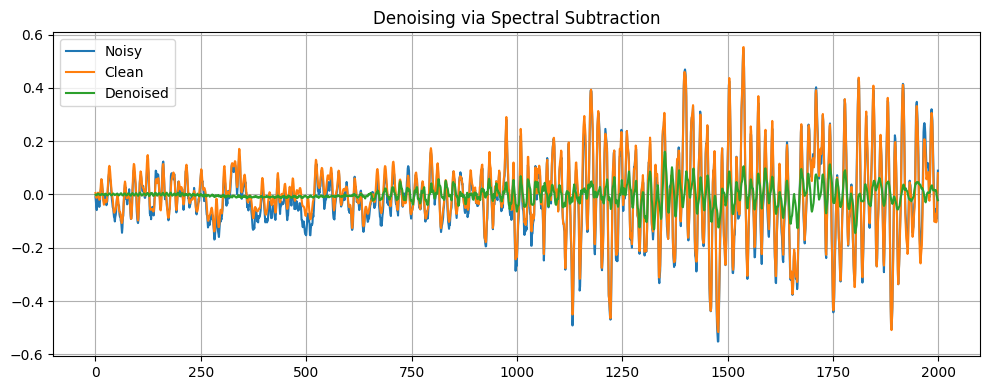

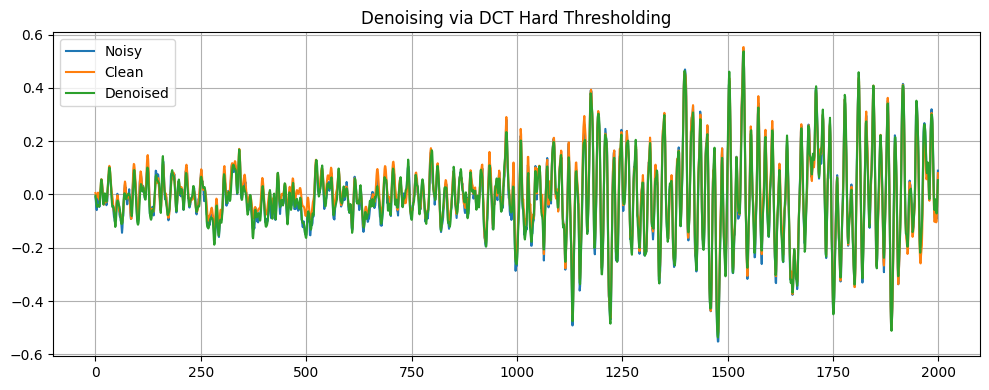

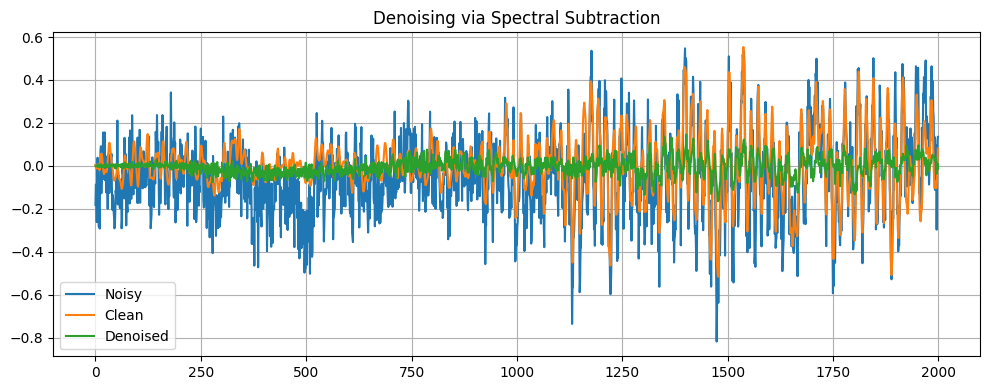

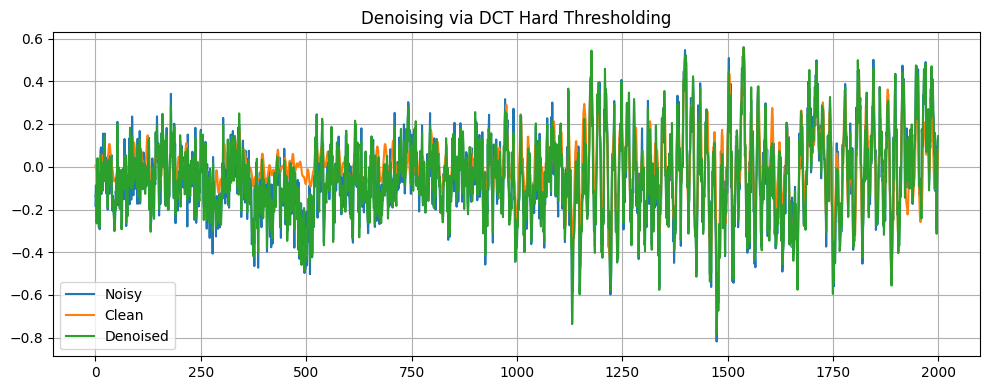

In [5]:
# Compare denoising methods
noisy_signal = noisy_signals['noise_1_20dB']  # Example noisy signal
spectral_denoised_signal = spectral_subtraction(noisy_signal, fs)
plot_comparison(noisy_signal, spectral_denoised_signal, clean_signal, "Denoising via Spectral Subtraction")
noisy_signals.keys()  # Display the keys of the noisy signals dictionary
dct_denoised_signal = hard_threshold_dct(noisy_signal, threshold=0.1)
plot_comparison(noisy_signal, dct_denoised_signal, clean_signal, "Denoising via DCT Hard Thresholding")

# Compare denoising methods
noisy_signal = noisy_signals['noise_2_5dB']  # Example noisy signal
spectral_denoised_signal = spectral_subtraction(noisy_signal, fs)
plot_comparison(noisy_signal, spectral_denoised_signal, clean_signal, "Denoising via Spectral Subtraction")
noisy_signals.keys()  # Display the keys of the noisy signals dictionary
dct_denoised_signal = hard_threshold_dct(noisy_signal, threshold=0.1)
plot_comparison(noisy_signal, dct_denoised_signal, clean_signal, "Denoising via DCT Hard Thresholding")

Here, we see that hard thresholding seem too lax and just superpose the noisy version. Some treshold will be tested.

On the other hand, spectral substraction is too strict and result in signal far too narrow. Some parameter can be adapted.

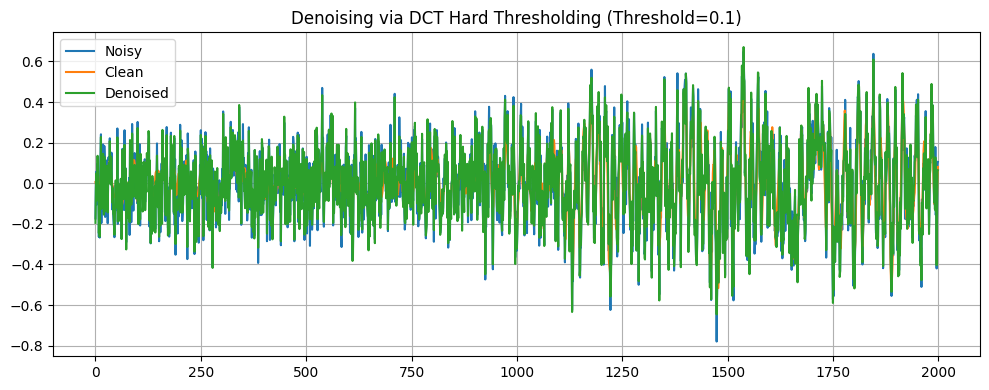

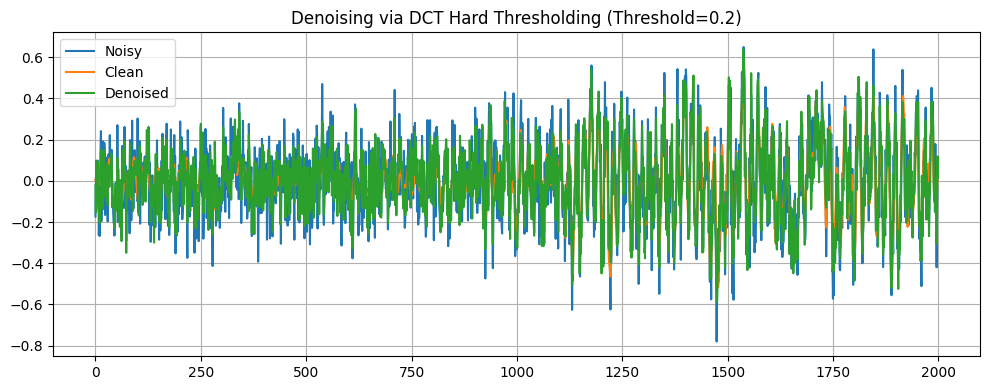

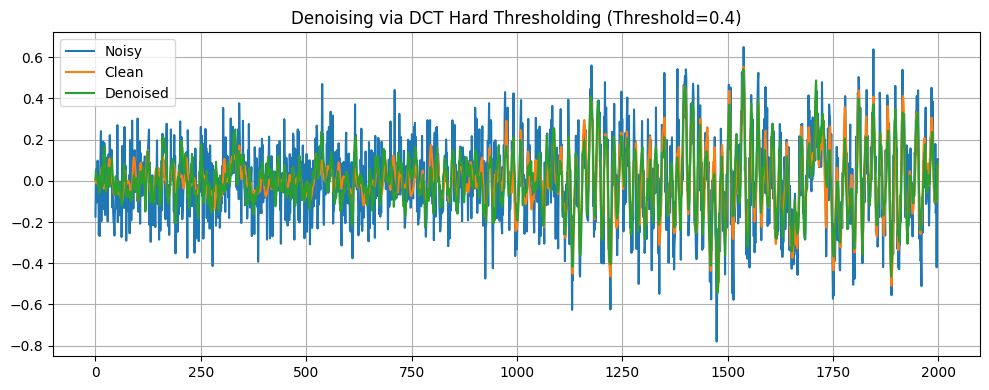

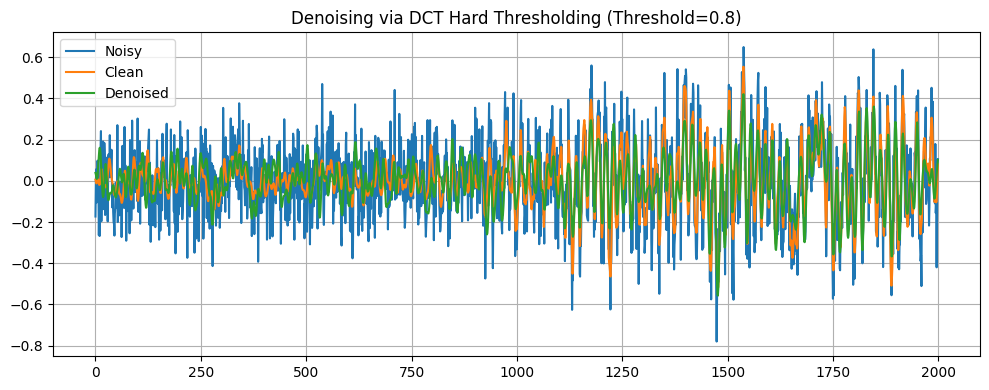

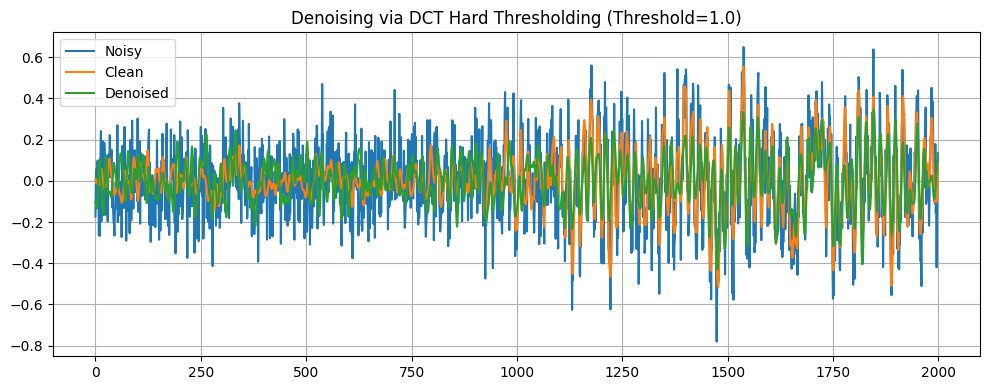

In [6]:
# Test the threshold parameter
noisy_signal = noisy_signals['noise_0_5dB']  # Example noisy signal
tresholds = [0.1, 0.2, 0.4, 0.8, 1.0]
for threshold in tresholds:
    dct_denoised_signal = hard_threshold_dct(noisy_signal, threshold)
    plot_comparison(noisy_signal, dct_denoised_signal, clean_signal, f"Denoising via DCT Hard Thresholding (Threshold={threshold})")

Visualy, the threeshold = 0.4 seem to work best. Other noisy signal should be tested.

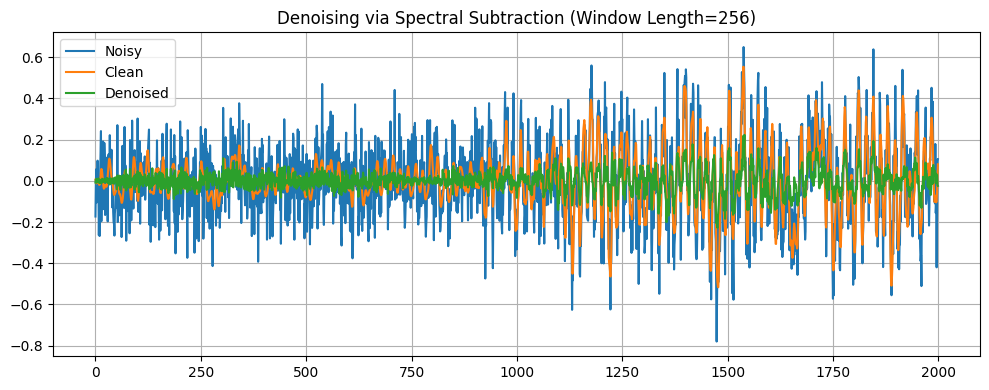

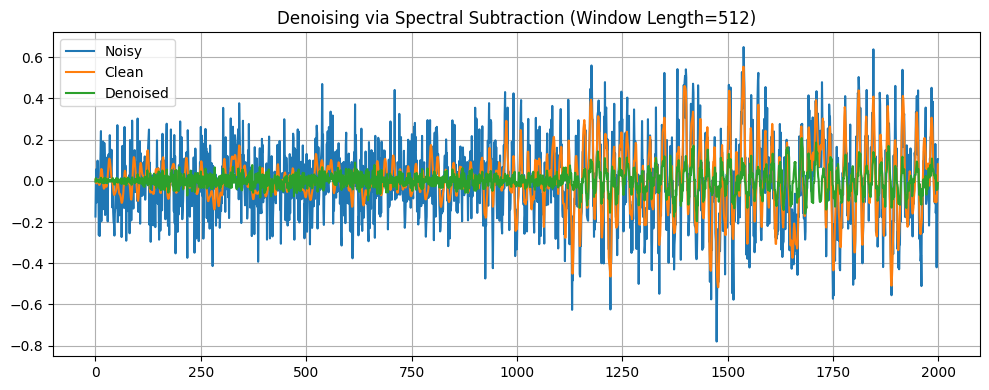

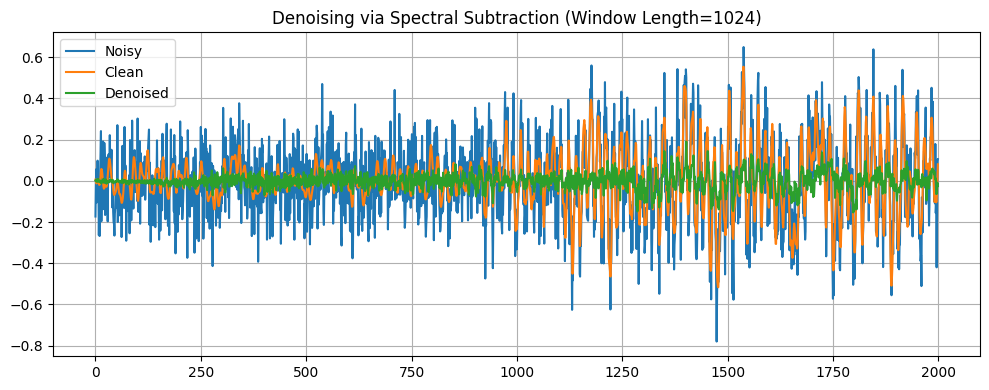

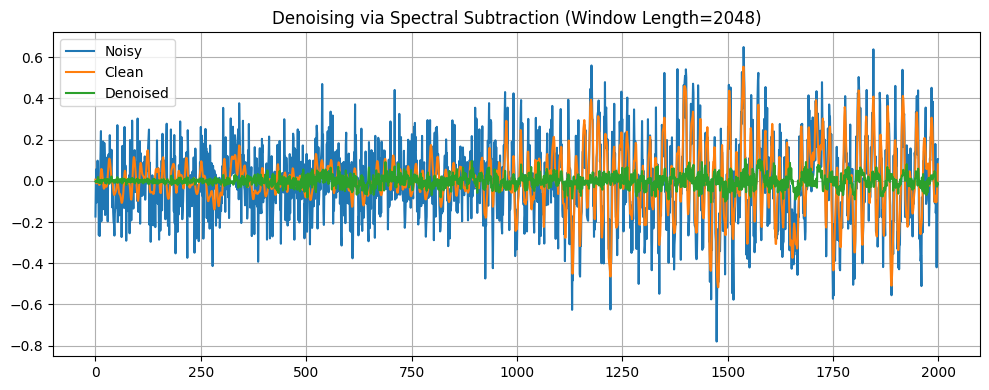

In [7]:
# Test the Length of the window
noisy_signal = noisy_signals['noise_0_5dB']  # Example noisy signal
window_lengths = [256, 512, 1024, 2048]
for window_length in window_lengths:
    f, t, Zxx = stft(noisy_signal, fs=fs, nperseg=window_length)
    noise_magnitude = np.mean(np.abs(Zxx[:, :10]), axis=1)
    
    # Subtract noise magnitude
    Zxx_denoised = Zxx - noise_magnitude[:, np.newaxis]
    Zxx_denoised = np.maximum(Zxx_denoised, 0)  # Ensure no negative values
    
    _, denoised_signal = istft(Zxx_denoised, fs=fs)
    plot_comparison(noisy_signal, denoised_signal, clean_signal, f"Denoising via Spectral Subtraction (Window Length={window_length})")

The smaller length of widows seem to perform better but I haven't mesured the frequency to see the performance.

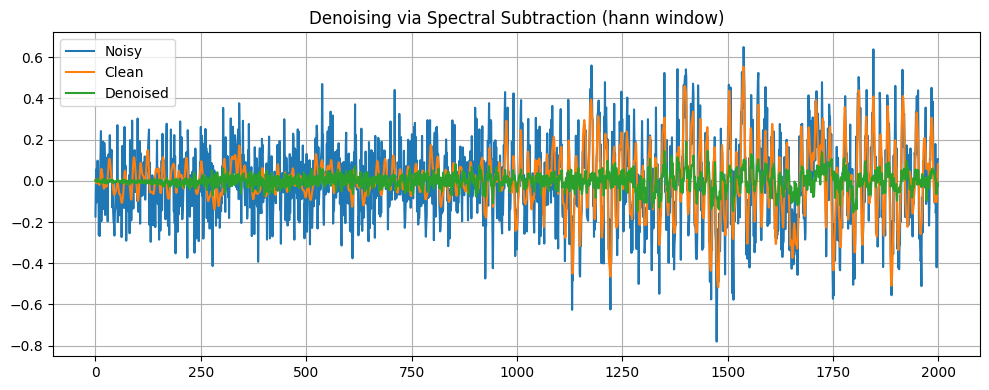

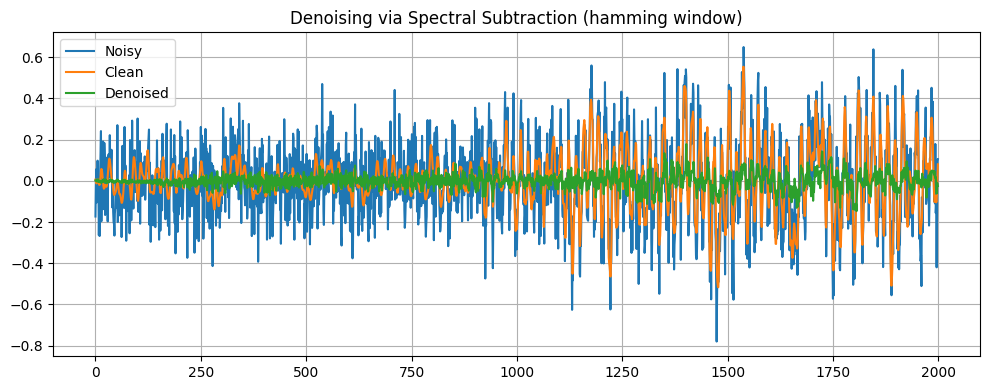

In [8]:
# Test the different type of window
window_types = ['hann', 'hamming']
for window_type in window_types:
    f, t, Zxx = stft(noisy_signal, fs=fs, nperseg=1024, window=window_type)
    noise_magnitude = np.mean(np.abs(Zxx[:, :10]), axis=1)
    
    # Subtract noise magnitude
    Zxx_denoised = Zxx - noise_magnitude[:, np.newaxis]
    Zxx_denoised = np.maximum(Zxx_denoised, 0)  # Ensure no negative values
    
    _, denoised_signal = istft(Zxx_denoised, fs=fs)
    plot_comparison(noisy_signal, denoised_signal, clean_signal, f"Denoising via Spectral Subtraction ({window_type} window)")